In [113]:
import tensorflow as tf
import numpy as np
import math
from censai import PhysicalModel, RIMSharedUnet
from censai.definitions import DTYPE
from censai.models import SharedUnetModel
from censai.data.lenses_tng import decode_train, decode_physical_model_info, preprocess
from censai.utils import nullwriter, rim_residual_plot as residual_plot, plot_to_image
import os, glob, time
from datetime import datetime
from tensorboard.plugins.hparams import api as hp
import random
    
    
RIM_HPARAMS = [
    "adam",
    "steps",
    "kappalog",
    "kappa_normalize",
    "kappa_init",
    "source_init"
]
UNET_MODEL_HPARAMS = [
    "filters",
    "filter_scaling",
    "kernel_size",
    "layers",
    "block_conv_layers",
    "strides",
    "bottleneck_kernel_size",
    "bottleneck_filters",
    "resampling_kernel_size",
    "input_kernel_size",
    "gru_kernel_size",
    "upsampling_interpolation",
    "batch_norm",
    "dropout_rate",
    "kernel_l2_amp",
    "bias_l2_amp",
    "kernel_l1_amp",
    "bias_l1_amp",
    "activation",
    "alpha",
    "initializer",
    "gru_architecture"
]

In [114]:
class BilinearInterpolation(tf.keras.layers.Layer):
    def __init__(self, height=40, width=40):
        super(BilinearInterpolation, self).__init__()
        self.height = height
        self.width = width

    def compute_output_shape(self, input_shape):
        return [None, self.height, self.width, 1]

    def get_config(self):
        return {
            'height': self.height,
            'width': self.width,
        }
    
    def build(self, input_shape):
        print("Building Bilinear Interpolation Layer with input shape:", input_shape)

    def advance_indexing(self, inputs, x, y):
        '''
        Numpy like advance indexing is not supported in tensorflow, hence, this function is a hack around the same method
        '''        
        shape = tf.shape(inputs)
        batch_size = shape[0]
        
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, self.height, self.width))
        indices = tf.stack([b, y[..., 0], x[..., 0]], 3)
        return tf.gather_nd(inputs, indices)

    def call(self, images , coordinates):
#         images, theta = inputs
#         images , coordinates = inputs
#         homogenous_coordinates = self.grid_generator(batch=tf.shape(images)[0])
#         return self.interpolate(images, homogenous_coordinates, theta)
        return self.interpolate(images, coordinates)

#     def grid_generator(self, batch):
#         x = tf.linspace(-1, 1, self.width)
#         y = tf.linspace(-1, 1, self.height)
            
#         xx, yy = tf.meshgrid(x, y)
#         xx = tf.reshape(xx, (-1,))
#         yy = tf.reshape(yy, (-1,))
#         print(xx.shape)
#         homogenous_coordinates = tf.stack([xx, yy])
#         homogenous_coordinates = tf.cast(homogenous_coordinates, dtype=tf.float32)
#         return homogenous_coordinates
    
#     def interpolate(self, images, homogenous_coordinates, theta):
    def interpolate(self, images, coordinates):
        # coordinates shape = [batch, pixels, pixels, 2]
#         with tf.name_scope("Transformation"):
#             transformed = tf.matmul(theta, homogenous_coordinates)
#             transformed = tf.transpose(transformed, perm=[0, 2, 1])
#             transformed = tf.reshape(transformed, [-1, self.height, self.width, 2])
                
#             x_transformed = transformed[:, :, :, 0]
#             y_transformed = transformed[:, :, :, 1]
                
#             x = ((x_transformed + 1.) * tf.cast(self.width, dtype=tf.float32)) * 0.5
#             y = ((y_transformed + 1.) * tf.cast(self.height, dtype=tf.float32)) * 0.5

        with tf.name_scope("VariableCasting"):
            x, y = tf.split(coordinates, 2, axis=3)
            x0 = tf.cast(tf.math.floor(x), dtype=tf.int32)
            x1 = x0 + 1
            y0 = tf.cast(tf.math.floor(y), dtype=tf.int32)
            y1 = y0 + 1
            
            x0 = tf.clip_by_value(x0, 0, self.width-1)
            x1 = tf.clip_by_value(x1, 0, self.width-1)
            y0 = tf.clip_by_value(y0, 0, self.height-1)
            y1 = tf.clip_by_value(y1, 0, self.height-1)
            x = tf.clip_by_value(x, 0, tf.cast(self.width, dtype=tf.float32)-1.0)
            y = tf.clip_by_value(y, 0, tf.cast(self.height, dtype=tf.float32)-1)

        with tf.name_scope("AdvanceIndexing"):
            Ia = self.advance_indexing(images, x0, y0)
            Ib = self.advance_indexing(images, x0, y1)
            Ic = self.advance_indexing(images, x1, y0)
            Id = self.advance_indexing(images, x1, y1)

        with tf.name_scope("Interpolation"):
            x0 = tf.cast(x0, dtype=tf.float32)
            x1 = tf.cast(x1, dtype=tf.float32)
            y0 = tf.cast(y0, dtype=tf.float32)
            y1 = tf.cast(y1, dtype=tf.float32)
                            
            wa = (x1-x) * (y1-y)
            wb = (x1-x) * (y-y0)
            wc = (x-x0) * (y1-y)
            wd = (x-x0) * (y-y0)

#             wa = tf.expand_dims(wa, axis=3)
#             wb = tf.expand_dims(wb, axis=3)
#             wc = tf.expand_dims(wc, axis=3)
#             wd = tf.expand_dims(wd, axis=3)
                        
        return tf.math.add_n([wa*Ia + wb*Ib + wc*Ic + wd*Id])

In [122]:
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
from censai.definitions import DTYPE


class PhysicalModel:
    """
    Physical model to be passed to RIM class at instantiation
    """
    def __init__(
            self,
            pixels,            # 512
            psf_sigma=0.06,    # gaussian PSF
            src_pixels=None,   # 128 for cosmos
            kappa_pixels=None,
            image_fov=7.68,
            src_fov=3.0,
            kappa_fov=7.68,
            method="conv2d",
            noise_rms=1,
            raytracer=None
    ):
        if src_pixels is None:
            src_pixels = pixels  # assume src has the same shape
        if kappa_pixels is None:
            kappa_pixels = pixels
        self.image_fov = image_fov
        self.psf_sigma = psf_sigma
        self.src_fov = src_fov
        self.pixels = pixels
        self.src_pixels = src_pixels
        self.kappa_pixels = kappa_pixels
        self.kappa_fov = kappa_fov
        self.method = method
        self.noise_rms = noise_rms
        self.raytracer = raytracer
        self.set_deflection_angle_vars()
        self.PSF = self.psf_model()
        if kappa_pixels != pixels:
            self.kappa_to_image_grid = self._kappa_to_image_grid
        else:
            self.kappa_to_image_grid = tf.identity
            
        self.bilinear_interpolation = BilinearInterpolation(pixels, pixels)


    def deflection_angle(self, kappa):
#         kappa = self.kappa_to_image_grid(kappa)  # resampling to shape of image
        if self.method == "conv2d":
            alpha_x = tf.nn.conv2d(kappa, self.xconv_kernel, [1, 1, 1, 1], "SAME") * (self.dx_kap**2/np.pi)
            alpha_y = tf.nn.conv2d(kappa, self.yconv_kernel, [1, 1, 1, 1], "SAME") * (self.dx_kap**2/np.pi)
 
        elif self.method == "unet":
            alpha = self.raytracer(kappa)
            alpha_x, alpha_y = tf.split(alpha, 2, axis=-1)

        elif self.method == "fft":
            """
            The convolution using the Convolution Theorem.
            Since we use FFT to justify this approach, we must zero pad the kernel and kappa map to transform 
            a 'circular convolution' (assumed by our use of FFT) into an an 'acyclic convolution' 
            (sum from m=0 to infinity).
            
            To do that, we pad our signal with N-1 trailing zeros for each dimension. N = 2*pixels+1 since 
            our kernel has this shape.
            
            This approach has complexity O((4*pixels)^2 * log^2(4 * pixels)), and is precise to about rms=2e-5 of the 
            true convolution for the deflection angles.
            """
            # pad the kernel and compute itf fourier transform
            xconv_kernel = tf.image.pad_to_bounding_box(self.xconv_kernel[..., 0], 0, 0, 4*self.pixels+1, 4*self.pixels+1)
            yconv_kernel = tf.image.pad_to_bounding_box(self.yconv_kernel[..., 0], 0, 0, 4*self.pixels+1, 4*self.pixels+1)
            x_kernel_tilde = tf.signal.fft2d(tf.cast(-xconv_kernel[..., 0], tf.complex64))
            y_kernel_tilde = tf.signal.fft2d(tf.cast(-yconv_kernel[..., 0], tf.complex64))

            batch_size = kappa.shape[0]
            alpha_x = []
            alpha_y = []
            for i in range(batch_size):
                kap = tf.image.pad_to_bounding_box(kappa[i, ...],  # pad kappa one by one to save memory space
                                                   offset_height=0,
                                                   offset_width=0,
                                                   target_width=4 * self.pixels + 1,
                                                   target_height=4 * self.pixels + 1)
                kappa_tilde = tf.signal.fft2d(tf.cast(kap[..., 0], tf.complex64))
                alpha_x.append(tf.math.real(tf.signal.ifft2d(kappa_tilde * x_kernel_tilde)) * (self.dx_kap**2/np.pi))
                alpha_y.append(tf.math.real(tf.signal.ifft2d(kappa_tilde * y_kernel_tilde)) * (self.dx_kap**2/np.pi))
            alpha_x = tf.stack(alpha_x, axis=0)[..., tf.newaxis]
            alpha_x = tf.image.crop_to_bounding_box(alpha_x,
                                                    offset_height=self.pixels,
                                                    offset_width=self.pixels,
                                                    target_width=self.pixels,
                                                    target_height=self.pixels)
            alpha_y = tf.stack(alpha_y, axis=0)[..., tf.newaxis]
            alpha_y = tf.image.crop_to_bounding_box(alpha_y,
                                                    offset_height=self.pixels,
                                                    offset_width=self.pixels,
                                                    target_width=self.pixels,
                                                    target_height=self.pixels)
        else:
            raise ValueError(f"{self.method} is not in [conv2d, unet, fft]")
        return alpha_x, alpha_y

    def log_likelihood(self, source, kappa, y_true):
        y_pred = self.forward(source, kappa)
#         lam = self.lagrange_multiplier(y_true, y_pred)
        return 0.5 * tf.reduce_sum((y_pred - y_true)**2/self.noise_rms**2, axis=(1, 2, 3))
#         return 0.5 * tf.reduce_sum((y_pred - y_true) ** 2 / self.noise_rms ** 2, axis=(1, 2, 3))

    @staticmethod
    def lagrange_multiplier(y_true, y_pred):
        return tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3), keepdims=True) / tf.reduce_sum(y_true**2, axis=(1, 2, 3), keepdims=True)

    def forward(self, source, kappa):
        im = self.lens_source(source, kappa)
        im = self.convolve_with_psf(im)
        return im

    def noisy_forward(self, source, kappa, noise_rms):
        im = self.lens_source(source, kappa)
        noise = tf.random.normal(im.shape, mean=0, stddev=noise_rms)
        out = self.convolve_with_psf(im)  # convolve before adding noise, otherwise it correlates the noise
        out = out + noise
        return out
#         return im + noise

    def lens_source(self, source, kappa):
        alpha_x, alpha_y = self.deflection_angle(kappa)
        x_src = self.ximage - alpha_x
        y_src = self.yimage - alpha_y
#         x_src_pix, y_src_pix = self.src_coord_to_pix(x_src, y_src)
        x_src_pix, y_src_pix = self.src_coord_to_pix(x_src, y_src, tf.reduce_max(x_src, axis=(1, 2, 3), keepdims=True), tf.reduce_max(y_src, axis=(1, 2, 3), keepdims=True))
        warp = tf.concat([x_src_pix, y_src_pix], axis=-1)
#         im = tfa.image.resampler(source, warp)  # bilinear interpolation of source on warp grid
        im = self.bilinear_interpolation(source, warp)
        return im

    def lens_source_func(self, kappa, xs=0., ys=0., es=0., w=0.1):
        alpha_x, alpha_y = self.deflection_angle(kappa)
        # lens equation
        beta1 = self.ximage - alpha_x
        beta2 = self.yimage - alpha_y
        # sample intensity directly from the functional form
        rho_sq = (beta1 - xs) ** 2 / (1 - es) + (beta2 - ys) ** 2 * (1 - es)
        lens = tf.math.exp(-0.5 * rho_sq / w ** 2)  # / 2 / np.pi / w**2
        lens = self.convolve_with_psf(lens)
        return lens

    def lens_source_func_given_alpha(self, alpha, xs=0., ys=0., es=0., w=0.1):
        alpha1, alpha2 = tf.split(alpha, 2, axis=-1)
        # lens equation
        beta1 = self.ximage - alpha1
        beta2 = self.yimage - alpha2
        # sample intensity directly from the functional form
        rho_sq = (beta1 - xs) ** 2 / (1 - es) + (beta2 - ys) ** 2 * (1 - es)
        lens = tf.math.exp(-0.5 * rho_sq / w ** 2)  # / 2 / np.pi / w**2
        lens = self.convolve_with_psf(lens)
        return lens

#     def src_coord_to_pix(self, x, y):
#         dx = self.src_fov / (self.src_pixels - 1)
#         xmin = -0.5 * self.src_fov
#         ymin = -0.5 * self.src_fov
#         i_coord = (x - xmin) / dx
#         j_coord = (y - ymin) / dx
#         return i_coord, j_coord
    
    def src_coord_to_pix(self, x, y, xmax, ymax):
        dx = 2*xmax / (self.src_pixels - 1)
        dy = 2*ymax / (self.src_pixels - 1)
        xmin = - xmax
        ymin = - ymax
        i_coord = (x - xmin) / dx
        j_coord = (y - ymin) / dy
        return i_coord, j_coord

    def kap_coord_to_pix(self, x, y):
        dx = self.kappa_fov / (self.kappa_pixels - 1)
        xmin = -0.5 * self.kappa_fov
        ymin = -0.5 * self.kappa_fov
        i_coord = (x - xmin) / dx
        j_coord = (y - ymin) / dx
        return i_coord, j_coord

    def _kappa_to_image_grid(self, kappa):
        batch_size = kappa.shape[0]
        x_coord, y_coord = self.kap_coord_to_pix(self.xkappa, self.ykappa)
        warp = tf.concat([x_coord, y_coord], axis=-1)
        warp = tf.tile(warp, [batch_size, 1, 1, 1])  # make sure warp has same batch size has kappa
        kappa = tfa.image.resampler(kappa, warp)
        return kappa

    def set_deflection_angle_vars(self):
        self.dx_kap = self.kappa_fov / (self.pixels - 1)  # dx on image grid

        # Convolution kernel
        x = tf.linspace(-1, 1, 2 * self.pixels + 1) * self.image_fov
        xx, yy = tf.meshgrid(x, x)
        rho = xx**2 + yy**2
        xconv_kernel = -self._safe_divide(xx, rho)
        yconv_kernel = -self._safe_divide(yy, rho)
        # reshape to [filter_height, filter_width, in_channels, out_channels]
        self.xconv_kernel = tf.cast(xconv_kernel[..., tf.newaxis, tf.newaxis], dtype=DTYPE)
        self.yconv_kernel = tf.cast(yconv_kernel[..., tf.newaxis, tf.newaxis], dtype=DTYPE)

        # coordinates for image
        x = tf.linspace(-1, 1, self.pixels) * self.image_fov / 2
        xx, yy = tf.meshgrid(x, x)
        # reshape for broadcast to [batch_size, pixels, pixels, 1]
        self.ximage = tf.cast(xx[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)
        self.yimage = tf.cast(yy[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)

        # Coordinates for kappa
        xkappa = tf.cast(tf.linspace(-1, 1, self.pixels), dtype=DTYPE) * self.kappa_fov / 2
        xkappa, ykappa = tf.meshgrid(xkappa, xkappa)
        self.xkappa = tf.cast(xkappa[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)
        self.ykappa = tf.cast(ykappa[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)


    @staticmethod
    def _safe_divide(num, denominator):
        out = np.zeros_like(num)
        out[denominator != 0] = num[denominator != 0] / denominator[denominator != 0]
        return out

    def psf_model(self):
        pixel_scale = self.image_fov / self.pixels
        cutout_size = int(10 * self.psf_sigma / pixel_scale)
        r_squared = self.ximage**2 + self.yimage**2
        psf = tf.math.exp(-0.5 * r_squared / self.psf_sigma**2)
        psf = tf.image.crop_to_bounding_box(psf,
                                            offset_height=self.pixels//2 - cutout_size//2,
                                            offset_width=self.pixels//2 - cutout_size//2,
                                            target_width=cutout_size,
                                            target_height=cutout_size)
        psf /= tf.reduce_sum(psf)
        psf = tf.reshape(psf, shape=[cutout_size, cutout_size, 1, 1])
        return psf

    def convolve_with_psf(self, images):
        convolved_images = tf.nn.conv2d(images, self.PSF, [1, 1, 1, 1], padding="SAME")
        return convolved_images




In [123]:
from censai.models.layers import UnetDecodingLayer, UnetEncodingLayer
# from censai.models.layers.conv_gru_component import ConvGRUBlock
from censai.models.utils import get_activation
from censai.definitions import DTYPE, lrelu4p
# from censai.models.layers.conv_gru import ConvGRU

# import tensorflow as tf
from censai.definitions import DTYPE


class ConvGRU(tf.keras.layers.Layer):
    def __init__(self, filters=32, kernel_size=5, **kwargs):
        super(ConvGRU, self).__init__(dtype=DTYPE, **kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
    
    def build(self, input_shape):
        self.Wz = tf.keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=(1, 1),
#             activation='sigmoid',
            padding='same',
#             kernel_initializer=tf.keras.initializers.GlorotUniform()
        )
        self.Uz = tf.keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=(1, 1),
#             activation='sigmoid',
            padding='same',
#             kernel_initializer=tf.keras.initializers.GlorotUniform()
        )
        self.Bz = tf.Variable(tf.random.truncated_normal(shape=input_shape[1:], mean=0.0, stddev=0.5, dtype=DTYPE))
        
        self.Wr = tf.keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=(1, 1),
#             activation='sigmoid',
            padding='same',
#             kernel_initializer=tf.keras.initializers.GlorotUniform()
        )
        self.Ur = tf.keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=(1, 1),
#             activation='sigmoid',
            padding='same',
#             kernel_initializer=tf.keras.initializers.GlorotUniform()
        )
        self.Br = tf.Variable(tf.random.truncated_normal(shape=input_shape[1:], mean=0.0, stddev=0.5, dtype=DTYPE))
        
        self.Wh = tf.keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=(1, 1),
#             activation='sigmoid',
            padding='same',
#             kernel_initializer=tf.keras.initializers.GlorotUniform()
        )
        self.Uh = tf.keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=(1, 1),
#             activation='sigmoid',
            padding='same',
#             kernel_initializer=tf.keras.initializers.GlorotUniform()
        )
        self.Bh = tf.Variable(tf.random.truncated_normal(shape=input_shape[1:], mean=0.0, stddev=0.5, dtype=DTYPE))


    def call(self, x, ht):
        """
        Compute the new state tensor h_{t+1}.
        """
#         stacked_input = tf.concat([features, ht], axis=3)
        z = tf.nn.sigmoid(self.Wz(x) + self.Uz(ht) + self.Bz)  # Update gate vector
        r = tf.nn.sigmoid(self.Wr(x) + self.Ur(ht) + self.Br)    # Reset gate vector
        h_tilde = tf.nn.tanh(self.Wh(x) + self.Uh(r * ht) + self.Bh)  # candidate activation
        new_state = (1 - z) * ht + z * h_tilde
#         r_state = tf.multiply(r, ht)
#         stacked_r_state = tf.concat([features, r_state], axis=3)
#         tilde_h = self.candidate_activation_gate(stacked_r_state)  # candidate activation gate
#         new_state = tf.multiply(z, ht) + tf.multiply(1 - z, tilde_h)
        return new_state  # h_{t+1}



class ConvGRUBlock(tf.keras.Model):
    """
    Abstraction for the recurrent block inside the RIM
    """
    def __init__(
            self,
            filters,
            kernel_size=5,
            activation=tf.keras.layers.LeakyReLU()
    ):
        gru_filters = filters
        super(ConvGRUBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=1,
            activation=activation,
            padding='same')
        self.gru1 = ConvGRU(gru_filters, kernel_size)
        self.gru2 = ConvGRU(gru_filters, kernel_size)

    def call(self, inputs, state):
        ht_11, ht_12 = tf.split(state, 2, axis=3)
        gru_1_out  = self.gru1(inputs, ht_11)
        gru_1_outE = self.conv1(gru_1_out)
        gru_2_out  = self.gru2(gru_1_outE, ht_12)
        ht = tf.concat([gru_1_out, gru_2_out], axis=3)
        xt = gru_2_out
#         ht = self.gru1(inputs, state)
        return ht, ht




In [124]:
class SharedUnetModel(tf.keras.Model):
    def __init__(
            self,
            name="RIMUnetModel",
            filters=32,
            filter_scaling=1,
            kernel_size=3,
            layers=2,
            block_conv_layers=2,
            strides=2,
            output_filters=1,
            bottleneck_kernel_size=None,
            bottleneck_filters=None,
            resampling_kernel_size=None,
            input_kernel_size=11,
            gru_kernel_size=None,
            upsampling_interpolation=False,
            kernel_l1_amp=0.,
            bias_l1_amp=0.,
            kernel_l2_amp=0.,
            bias_l2_amp=0.,
            activation="leaky_relu",
            alpha=0.1,
            use_bias=True,
            trainable=True,
            batch_norm=False,
            dropout_rate=None,
            gru_architecture="concat",
            initializer="glorot_uniform",
    ):
        print("My ShareUNet")
        super(SharedUnetModel, self).__init__()
        activation = lrelu4p
        strides=4
        common_params = {"activation": activation, "padding": "same"}
        numfeat_1, numfeat_2, numfeat_3, numfeat_4 = 32, 64, 64, 64

        self.strides = 2
        self.Lc11 = tf.keras.layers.Conv2D(numfeat_1, (13, 13),  **common_params)
        self.Lp13 = tf.keras.layers.Conv2D(numfeat_1, (5, 5), strides=strides, **common_params)

        self.Lc21 = tf.keras.layers.Conv2D(numfeat_2, (5, 5), **common_params)
        self.Lc22 = tf.keras.layers.Conv2D(numfeat_2, (5, 5), **common_params)
        self.Lp23 = tf.keras.layers.Conv2D(numfeat_2, (5, 5), strides=strides, **common_params)

        self.Lc31 = tf.keras.layers.Conv2D(numfeat_3, (5, 5), **common_params)
        self.Lc32 = tf.keras.layers.Conv2D(numfeat_3, (5, 5), **common_params)
        self.Lp33 = tf.keras.layers.Conv2D(numfeat_3, (5, 5), strides=strides, **common_params)

        self.LcZ1 = tf.keras.layers.Conv2D(numfeat_4, (5, 5), **common_params)
        self.LcZ2 = tf.keras.layers.Conv2D(numfeat_4, (5, 5), **common_params)

        self.Lu61 = tf.keras.layers.Conv2DTranspose(numfeat_3, (5, 5), strides=strides, **common_params)
        self.Lc62 = tf.keras.layers.Conv2D(numfeat_3, (5, 5), **common_params)
        self.Lc63 = tf.keras.layers.Conv2D(numfeat_3, (5, 5), **common_params)

        self.Lu71 = tf.keras.layers.Conv2DTranspose(numfeat_2, (5, 5), strides=strides, **common_params)
        self.Lc72 = tf.keras.layers.Conv2D(numfeat_2, (5, 5), **common_params)
        self.Lc73 = tf.keras.layers.Conv2D(numfeat_2, (5, 5), **common_params)

        self.Lu81 = tf.keras.layers.Conv2DTranspose(numfeat_1, (5, 5), strides=strides, **common_params)
        self.Lc82 = tf.keras.layers.Conv2D(numfeat_1, (5, 5), **common_params)
        self.Lc83 = tf.keras.layers.Conv2D(numfeat_1, (5, 5), **common_params)
        self.Loutputs = tf.keras.layers.Conv2D(2, (3, 3), activation='linear', padding='same')

        self.GRU_COMP1 = ConvGRUBlock(numfeat_1)
        self.GRU_COMP2 = ConvGRUBlock(numfeat_2)
        self.GRU_COMP3 = ConvGRUBlock(numfeat_3)
        self.GRU_COMP4 = ConvGRUBlock(numfeat_4)


#     def __call__(self, source, kappa, source_grad, kappa_grad, states, lens_pred, lens_true):
#         return self.call(source, kappa, source_grad, kappa_grad, states, lens_pred, lens_true)

#     def call(self, source, kappa, source_grad, kappa_grad, states, lens_pred, lens_true):
#         delta_xt = tf.concat([source, source_grad, kappa, kappa_grad, lens_pred, lens_true], axis=-1)
#     def __call__(self, source, kappa, source_grad, kappa_grad, states):
#         return self.call(source, kappa, source_grad, kappa_grad, states)

#     def call(self, source, kappa, source_grad, kappa_grad, states):
#         delta_xt = tf.concat([source, source_grad, kappa, kappa_grad], axis=-1)
#         delta_xt = self.input_layer(delta_xt)

    def call(self, source, kappa, source_grad, kappa_grad, states):
#     def call(self, source, kappa, source_grad, kappa_grad):
        x = tf.concat([tf.identity(source), source_grad, tf.identity(kappa), kappa_grad], axis=-1)
        ht_1, ht_2, ht_3, ht_4 = states

        x = self.Lc11(x)
        c1_gru, c1_gru_state = self.GRU_COMP1(x, ht_1)  # GRU in the middle of the skip connection
#         c1 = tf.identity(x)
        x = self.Lp13(x)  # downsampling layer

        x = self.Lc21(x)
        x = self.Lc22(x)
        c2_gru, c2_gru_state = self.GRU_COMP2(x, ht_2)
#         c2 = tf.identity(x)
        x = self.Lp23(x)  # downsampling layer

        x = self.Lc31(x)
        x = self.Lc32(x)
        c3_gru, c3_gru_state = self.GRU_COMP3(x, ht_3)
#         c3 = tf.identity(x)
        x = self.Lp33(x)  # downsampling layer

        x = self.LcZ1(x)  # bottleneck of the architecture
        x = self.LcZ2(x)
        x, c4_gru_state = self.GRU_COMP4(x, ht_4)

        x = self.Lu61(x)   # upsampling layer
        x = tf.concat([x, c3_gru], axis=3)  # skip connection
#         x = tf.concat([x, c3], axis=3)
        x = self.Lc62(x)
        x = self.Lc63(x)

        x = self.Lu71(x)  # upsampling layer
        x = tf.concat([x, c2_gru], axis=3)  # skip connection
#         x = tf.concat([x, c2], axis=3)
        x = self.Lc72(x)
        x = self.Lc73(x)

        x = self.Lu81(x)  # upsampling layer
        x = tf.concat([x, c1_gru], axis=3)  # skip connection
#         x = tf.concat([x, c1], axis=3)
        x = self.Lc82(x)
        x = self.Lc83(x)

        delta_xt = self.Loutputs(x)
        delta_s, delta_k = tf.split(delta_xt, 2, axis=-1)
        source = source + delta_s
        kappa = kappa + delta_k

#         source = tf.nn.sigmoid(source)
        ht = [c1_gru_state, c2_gru_state, c3_gru_state, c4_gru_state]

        return source, kappa, ht

    def init_hidden_states(self, input_pixels, batch_size, constant=0.):
        feat = [32, 64, 64, 64]
        hidden_states = []
        for i, nf in enumerate(feat):
            pixels = input_pixels // 4**(i)
            hidden_states.append(
                constant * tf.ones(shape=[batch_size, pixels, pixels, 2*nf], dtype=DTYPE)
            )
        return hidden_states


In [137]:
import tensorflow as tf
# from censai.models import SharedUnetModel
from censai.definitions import logkappa_normalization, log_10, DTYPE, logit, lrelu4p
# from censai import PhysicalModel
from censai.utils import nulltape

# LAM = -0.10455389589556062
# LAM = -0.5369885858903738
# LAM = 0.42627448994956957 # applied with log_10
# LAM = -1.8944241461145863
LAM = -0.8
def boxcox(x):
    return (x**LAM - 1) / LAM

def boxcox_inverse(x):
#     return tf.math.exp(tf.math.log(G**(LAM-1) * LAM * x + 1) / LAM)
    return tf.math.exp(tf.math.log(G * LAM * x + 1) / LAM)

class RIMSharedUnet:
    """
    Architecture has only 1 Unet. Source and kappa information are stacked along channel dimension.

    There are 2 intended structures:
        1. Kappa has a larger shape than Source tensor:
            1 - Use a half-strided convolution to upsample the output of the Unet
            3 - Use bilinear interpolation to upsample
        2. Kappa and Source have the same tensor shape -> Identity layer

    In any case, we use the Source shape for the Unet
    """
    def __init__(
            self,
            physical_model: PhysicalModel,
            unet: SharedUnetModel,
            steps: int,
            adam=True,
            kappalog=True,
            kappa_normalize=False,
            source_link="relu",
            beta_1=0.99,
            beta_2=0.999,
            epsilon=1e-16,
            kappa_init=1e-1,
            source_init=1e-3
    ):
        self.physical_model = physical_model
        self.kappa_pixels = physical_model.kappa_pixels
        self.source_pixels = physical_model.src_pixels
        self.unet = unet
        self.steps = steps
        self.adam = adam
        self.kappalog = kappalog
        self._source_link_func = source_link
        self.kappa_normalize = kappa_normalize
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self._kappa_init = kappa_init
        self._source_init = source_init
        
#         self.kappa_inverse_link = tf.keras.layers.Lambda(lambda x: boxcox(log_10(x) + 3))
#         self.kappa_link = tf.keras.layers.Lambda(lambda x: 10**(boxcox_inverse(x) - 3))

        if self.kappalog:
            if self.kappa_normalize:
                self.kappa_inverse_link = tf.keras.layers.Lambda(lambda x: logkappa_normalization(log_10(x), forward=True))
                self.kappa_link = tf.keras.layers.Lambda(lambda x: 10**(logkappa_normalization(x, forward=False)))
            else:
                self.kappa_inverse_link = tf.keras.layers.Lambda(lambda x: log_10(x))
                self.kappa_link = tf.keras.layers.Lambda(lambda x: 10**x)
        else:
            self.kappa_link = tf.identity
            self.kappa_inverse_link = tf.identity
        

        if self._source_link_func == "exp":
            self.source_inverse_link = tf.keras.layers.Lambda(lambda x: tf.math.log(x + 1e-6))
            self.source_link = tf.keras.layers.Lambda(lambda x: tf.math.exp(x))
        elif self._source_link_func == "identity":
            self.source_inverse_link = tf.identity
            self.source_link = tf.identity
        elif self._source_link_func == "relu":
            self.source_inverse_link = tf.identity
            self.source_link = tf.nn.relu
        elif self._source_link_func == "sigmoid":
            self.source_inverse_link = logit
            self.source_link = tf.nn.sigmoid
        elif self._source_link_func == "lrelu4p":
            self.source_inverse_link = tf.identity
            self.source_link = lrelu4p
        else:
            raise NotImplementedError(f"{source_link} not in ['exp', 'identity', 'relu', 'lrelu4p', 'sigmoid']")

    def initial_states(self, batch_size):
        # Define initial guess in physical space, then apply inverse link function to bring them in prediction space
        source_init = self.source_inverse_link(tf.ones(shape=(batch_size, self.source_pixels, self.source_pixels, 1)) * self._source_init)
        kappa_init = self.kappa_inverse_link(tf.ones(shape=(batch_size, self.kappa_pixels, self.kappa_pixels, 1)) * self._kappa_init)
        states = self.unet.init_hidden_states(self.source_pixels, batch_size)
        return source_init, kappa_init, states

    def grad_update(self, grad1, grad2, time_step):
        if self.adam:
            if time_step == 0:  # reset mean and variance for time t=-1
                self._grad_mean1 = tf.zeros_like(grad1)
                self._grad_var1 = tf.zeros_like(grad1)
                self._grad_mean2 = tf.zeros_like(grad2)
                self._grad_var2 = tf.zeros_like(grad2)
            self._grad_mean1 = self. beta_1 * self._grad_mean1 + (1 - self.beta_1) * grad1
            self._grad_var1  = self.beta_2 * self._grad_var1 + (1 - self.beta_2) * tf.square(grad1)
            self._grad_mean2 = self. beta_1 * self._grad_mean2 + (1 - self.beta_1) * grad2
            self._grad_var2  = self.beta_2 * self._grad_var2 + (1 - self.beta_2) * tf.square(grad2)
            # for grad update, unbias the moments
            m_hat1 = self._grad_mean1 / (1 - self.beta_1**(time_step + 1))
            v_hat1 = self._grad_var1 / (1 - self.beta_2**(time_step + 1))
            m_hat2 = self._grad_mean2 / (1 - self.beta_1**(time_step + 1))
            v_hat2 = self._grad_var2 / (1 - self.beta_2**(time_step + 1))
            return m_hat1 / (tf.sqrt(v_hat1) + self.epsilon), m_hat2 / (tf.sqrt(v_hat2) + self.epsilon)
        else:
            return grad1, grad2

#     def time_step(self, source, kappa, source_grad, kappa_grad, states, lens_pred, lens_true):
#         source, kappa, states = self.unet(source, kappa, source_grad, kappa_grad, states, lens_pred, lens_true)
#         return source, kappa, states

    def time_step(self, source, kappa, source_grad, kappa_grad, states):
        source, kappa, states = self.unet(source, kappa, source_grad, kappa_grad, states)
        return source, kappa, states


    def __call__(self, lensed_image, outer_tape=nulltape):
        return self.call(lensed_image, outer_tape)

    def call(self, lensed_image, outer_tape=nulltape):
        """
        Used in training. Return linked kappa and source maps.
        """
        batch_size = lensed_image.shape[0]
        source, kappa, states = self.initial_states(batch_size)
#         with outer_tape.stop_recording():
#             y_true = tf.image.resize(lensed_image, size=(128, 128), antialias=True)
        source_series = tf.TensorArray(DTYPE, size=self.steps)  # equivalent to empty list and append, but using tensorflow
        kappa_series = tf.TensorArray(DTYPE, size=self.steps)
        chi_squared_series = tf.TensorArray(DTYPE, size=self.steps)
        for current_step in range(self.steps):
            with outer_tape.stop_recording():
                with tf.GradientTape() as g:
                    g.watch(source)
                    g.watch(kappa)
                    y_pred = self.physical_model.forward(self.source_link(source), self.kappa_link(kappa))
#                     y_pred /= tf.reduce_max(y_pred, keepdims=True)
#                     lam = tf.reduce_sum(lensed_image * y_pred, axis=(1, 2, 3)) / tf.reduce_sum(lensed_image**2, axis=(1, 2, 3))[..., tf.newaxis, tf.newaxis, tf.newaxis]
                    log_likelihood = 0.5 * tf.reduce_sum((y_pred - lensed_image) ** 2 / self.physical_model.noise_rms ** 2, axis=(1, 2, 3)) #+ 2000*tf.reduce_sum(source**2) #+ 20000*tf.reduce_sum(self.kappa_link(kappa)**2)
                    cost = tf.reduce_mean(log_likelihood)
                source_grad, kappa_grad = g.gradient(cost, [source, kappa])
                source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)
                source_grad, kappa_grad = [tf.clip_by_value(grad/1e4, -100, 100) for grad in [source_grad, kappa_grad]]

#                 y_pred = tf.image.resize(y_pred, size=(128, 128), antialias=True)
#                 y_pred /= tf.reduce_max(y_pred, keepdims=True)
#             source, kappa, states = self.time_step(source, kappa, source_grad, kappa_grad, states, y_pred, y_true)
            source, kappa, states = self.time_step(source, kappa, source_grad, kappa_grad, states)
            source_series = source_series.write(index=current_step, value=source)
            kappa_series = kappa_series.write(index=current_step, value=kappa)
            if current_step > 0:
                chi_squared_series = chi_squared_series.write(index=current_step - 1, value=log_likelihood)
        # last step score
        log_likelihood = self.physical_model.log_likelihood(y_true=lensed_image, source=self.source_link(source),
                                                            kappa=self.kappa_link(kappa))
        chi_squared_series = chi_squared_series.write(index=self.steps - 1, value=log_likelihood)
        return source_series.stack(), kappa_series.stack(), chi_squared_series.stack()

    def predict(self, lensed_image):
        """
        Used in inference. Return physical kappa and source maps.
        """
        batch_size = lensed_image.shape[0]
        source, kappa, states = self.initial_states(batch_size)
#         y_true = tf.image.resize(lensed_image, size=(128, 128), antialias=True)
        
        source_series = tf.TensorArray(DTYPE, size=self.steps)  # equivalent to empty list and append, but using tensorflow
        kappa_series = tf.TensorArray(DTYPE, size=self.steps)
        chi_squared_series = tf.TensorArray(DTYPE, size=self.steps)
        for current_step in range(self.steps):
            with tf.GradientTape() as g:
                g.watch(source)
                g.watch(kappa)
                y_pred = self.physical_model.forward(self.source_link(source), self.kappa_link(kappa))
#                 y_pred /= tf.reduce_max(y_pred, keepdims=True)
#                 lam = tf.reduce_sum(lensed_image * y_pred, axis=(1, 2, 3)) / tf.reduce_sum(lensed_image**2, axis=(1, 2, 3))[..., tf.newaxis, tf.newaxis, tf.newaxis]
                log_likelihood = 0.5 * tf.reduce_sum((y_pred - lensed_image) ** 2 / self.physical_model.noise_rms ** 2, axis=(1, 2, 3)) #+ 2000*tf.reduce_sum(source**2)#+ 20000*tf.reduce_sum(self.kappa_link(kappa)**2)
                cost = tf.reduce_mean(log_likelihood)
            source_grad, kappa_grad = g.gradient(cost, [source, kappa])
            source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)
            source_grad, kappa_grad = [tf.clip_by_value(grad/1e4, -100, 100) for grad in [source_grad, kappa_grad]]
#             y_pred = tf.image.resize(y_pred, size=(128, 128), antialias=True)  
#             y_pred /= tf.reduce_max(y_pred, keepdims=True)

#             source, kappa, states = self.time_step(source, kappa, source_grad, kappa_grad, states, y_pred, y_true)  
            source, kappa, states = self.time_step(source, kappa, source_grad, kappa_grad, states)            
            source_series = source_series.write(index=current_step, value=self.source_link(source))
            kappa_series = kappa_series.write(index=current_step, value=self.kappa_link(kappa))
            if current_step > 0:
                chi_squared_series = chi_squared_series.write(index=current_step - 1, value=log_likelihood)
        # last step score
        log_likelihood = self.physical_model.log_likelihood(y_true=lensed_image, source=self.source_link(source),
                                                            kappa=self.kappa_link(kappa))
        chi_squared_series = chi_squared_series.write(index=self.steps - 1, value=log_likelihood)
        return source_series.stack(), kappa_series.stack(), chi_squared_series.stack()  # stack along 0-th dimension

    def cost_function(self, lensed_image, source, kappa, outer_tape=nulltape, reduction=True):
        """

        Args:
            lensed_image: Batch of lensed images
            source: Batch of source images
            kappa: Batch of kappa maps
            reduction: Whether or not to reduce the batch dimension in computing the loss or not

        Returns: The average loss over pixels, time steps and (if reduction=True) batch size.

        """
        source_series, kappa_series, chi_squared = self.call(lensed_image, outer_tape=outer_tape)
        source_cost = tf.reduce_sum(tf.square(source_series - self.source_inverse_link(source)), axis=0) / self.steps
        kappa_cost = tf.reduce_sum(tf.square(kappa_series - self.kappa_inverse_link(kappa)), axis=0) / self.steps
        chi = tf.reduce_sum(chi_squared, axis=0) / self.steps

        if reduction:
            return tf.reduce_mean(source_cost) + tf.reduce_mean(kappa_cost), tf.reduce_mean(chi)
        else:
            return tf.reduce_mean(source_cost, axis=(1, 2, 3)) + tf.reduce_mean(kappa_cost, axis=(1, 2, 3)), chi



In [138]:
def main(args):
    files = []
    for dataset in args.datasets:
        files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
    np.random.shuffle(files)
    # Read concurrently from multiple records
    files = tf.data.Dataset.from_tensor_slices(files)
    dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=args.compression_type),
                               block_length=args.block_length, num_parallel_calls=tf.data.AUTOTUNE)
    # Read off global parameters from first example in dataset
    for physical_params in dataset.map(decode_physical_model_info):
        break
    # preprocessing
    dataset = dataset.map(decode_train).map(preprocess)
    if args.cache_file is not None:
        dataset = dataset.cache(args.cache_file)
#     train_dataset = dataset.shuffle(buffer_size=args.buffer_size).take(math.floor(args.train_split * args.total_items))\
#         .batch(args.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    train_dataset = dataset.take(math.floor(args.train_split * args.total_items))\
        .batch(args.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = dataset.skip(math.floor(args.train_split * args.total_items))\
        .take(math.ceil((1 - args.train_split) * args.total_items)).batch(args.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    # train_dataset = STRATEGY.experimental_distribute_dataset(train_dataset)
    # val_dataset = STRATEGY.experimental_distribute_dataset(val_dataset)
    if args.raytracer is not None:
        with open(os.path.join(args.raytracer, "ray_tracer_hparams.json"), "r") as f:
            raytracer_hparams = json.load(f)
    # with STRATEGY.scope():  # Replicate ops accross gpus
    if args.raytracer is not None:
        raytracer = RayTracer(**raytracer_hparams)
        # load last checkpoint in the checkpoint directory
        checkpoint = tf.train.Checkpoint(net=raytracer)
        manager = tf.train.CheckpointManager(checkpoint, directory=args.raytracer, max_to_keep=3)
        checkpoint.restore(manager.latest_checkpoint).expect_partial()
    else:
        raytracer = None
    phys = PhysicalModel(
        pixels=physical_params["pixels"].numpy(),
        kappa_pixels=physical_params["kappa pixels"].numpy(),
        src_pixels=physical_params["src pixels"].numpy(),
        image_fov=physical_params["image fov"].numpy(),
        kappa_fov=physical_params["kappa fov"].numpy(),
        src_fov=physical_params["source fov"].numpy(),
        method=args.forward_method,
        noise_rms=physical_params["noise rms"].numpy(),
        raytracer=raytracer,
        psf_sigma=physical_params["psf sigma"].numpy()
    )

    unet = SharedUnetModel(
        filters=args.filters,
        filter_scaling=args.filter_scaling,
        kernel_size=args.kernel_size,
        layers=args.layers,
        block_conv_layers=args.block_conv_layers,
        strides=args.strides,
        bottleneck_kernel_size=args.bottleneck_kernel_size,
        bottleneck_filters=args.bottleneck_filters,
        resampling_kernel_size=args.resampling_kernel_size,
        input_kernel_size=args.input_kernel_size,
        gru_kernel_size=args.gru_kernel_size,
        upsampling_interpolation=args.upsampling_interpolation,
        kernel_l2_amp=args.kernel_l2_amp,
        bias_l2_amp=args.bias_l2_amp,
        kernel_l1_amp=args.kernel_l1_amp,
        bias_l1_amp=args.bias_l1_amp,
        activation=args.activation,
        alpha=args.alpha,
        initializer=args.initializer,
        batch_norm=args.batch_norm,
        dropout_rate=args.dropout_rate
    )
    rim = RIMSharedUnet(
        physical_model=phys,
        unet=unet,
        steps=args.steps,
        adam=args.adam,
        kappalog=args.kappalog,
        source_link=args.source_link,
        kappa_normalize=args.kappa_normalize,
        kappa_init=args.kappa_init,
        source_init=args.source_init
    )
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=args.initial_learning_rate,
        decay_rate=args.decay_rate,
        decay_steps=args.decay_steps,
        staircase=args.staircase
    )
    optim = tf.keras.optimizers.deserialize(
        {
            "class_name": args.optimizer,
            'config': {"learning_rate": learning_rate_schedule}
        }
    )
    # weights for time steps in the loss function
    if args.time_weights == "uniform":
        wt = tf.ones(shape=(args.steps), dtype=DTYPE) / args.steps
    elif args.time_weights == "linear":
        wt = 2 * (tf.range(args.steps, dtype=DTYPE) + 1) / args.steps / (args.steps + 1)
    elif args.time_weights == "quadratic":
        wt = 6 * (tf.range(args.steps, dtype=DTYPE) + 1)**2 / args.steps / (args.steps + 1) / (2 * args.steps + 1)
    else:
        raise ValueError("time_weights must be in ['uniform', 'linear', 'quadratic']")
#     wt = (tf.range(args.steps, dtype=DTYPE) + 1)**4
#     wt /= tf.reduce_sum(wt)
    wt = wt[..., tf.newaxis]  # [steps, batch]
    # ==== Take care of where to write logs and stuff =================================================================
    if args.model_id.lower() != "none":
        logname = args.model_id + "_" + args.logname if args.logname is not None else args.model_id
        model_id = args.model_id
    elif args.logname is not None:
        logname = args.logname
        model_id = logname
    else:
        logname = args.logname_prefixe + "_" + datetime.now().strftime("%y-%m-%d_%H-%M-%S")
        model_id = logname
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, logname)
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        writer = tf.summary.create_file_writer(logdir)
    else:
        writer = nullwriter()
    # ===== Make sure directory and checkpoint manager are created to save model ===================================
    if args.model_dir.lower() != "none":
        checkpoints_dir = os.path.join(args.model_dir, logname)
        old_checkpoints_dir = os.path.join(args.model_dir, model_id)  # in case they differ we load model from a different directory
        if not os.path.isdir(checkpoints_dir):
            os.mkdir(checkpoints_dir)
            with open(os.path.join(checkpoints_dir, "script_params.json"), "w") as f:
                json.dump(vars(args), f, indent=4)
            with open(os.path.join(checkpoints_dir, "unet_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)[key] for key in UNET_MODEL_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
            with open(os.path.join(checkpoints_dir, "rim_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)[key] for key in RIM_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
        ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=rim.unet)
        checkpoint_manager = tf.train.CheckpointManager(ckpt, old_checkpoints_dir, max_to_keep=args.max_to_keep)
        save_checkpoint = True
        # ======= Load model if model_id is provided ===============================================================
        if args.model_id.lower() != "none":
            checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint)
        if old_checkpoints_dir != checkpoints_dir:  # save progress in another directory.
            checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)
    else:
        save_checkpoint = False
    # =================================================================================================================

    def train_step(X, source, kappa):
        with tf.GradientTape() as tape:
            tape.watch(rim.unet.trainable_variables)
            source_series, kappa_series, chi_squared = rim.call(X, outer_tape=tape)
            # mean over image residuals
            source_cost = tf.reduce_mean(tf.square(source_series - rim.source_inverse_link(source)), axis=(2, 3, 4))
            kappa_cost = tf.reduce_mean(tf.square(kappa_series - rim.kappa_inverse_link(kappa)), axis=(2, 3, 4))
            # weighted mean over time steps
            source_cost = tf.reduce_sum(wt * source_cost, axis=0)
            kappa_cost = tf.reduce_sum(wt * kappa_cost, axis=0)
            # final cost is mean over global batch size
            cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size
        gradient = tape.gradient(cost, rim.unet.trainable_variables)
        if args.clipping:
            gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
        optim.apply_gradients(zip(gradient, rim.unet.trainable_variables))
        chi_squared = tf.reduce_sum(chi_squared[-1]) / args.batch_size # take chi squared of converged prediction
        source_cost = tf.reduce_sum(source_cost) / args.batch_size
        kappa_cost = tf.reduce_sum(kappa_cost) / args.batch_size
        return cost, chi_squared, source_cost, kappa_cost

    # @tf.function
    # def distributed_train_step(dist_inputs):
    #     per_replica_losses, per_replica_chi_squared, per_replica_source_cost, per_replica_kappa_cost = STRATEGY.run(train_step, args=(dist_inputs,))
    #     # Replica losses are aggregated by summing them
    #     global_loss = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
    #     global_chi_squared = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_chi_squared, axis=None)
    #     global_source_cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_source_cost, axis=None)
    #     global_kappa_cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_kappa_cost, axis=None)
    #     return global_loss, global_chi_squared, global_source_cost, global_kappa_cost

    def test_step(X, source, kappa):
        source_series, kappa_series, chi_squared = rim.call(X)
        # mean over image residuals
        source_cost = tf.reduce_mean(tf.square(source_series - rim.source_inverse_link(source)), axis=(2, 3, 4))
        kappa_cost = tf.reduce_mean(tf.square(kappa_series - rim.kappa_inverse_link(kappa)), axis=(2, 3, 4))
        # weighted mean over time steps
        source_cost = tf.reduce_sum(wt * source_cost, axis=0)
        kappa_cost = tf.reduce_sum(wt * kappa_cost, axis=0)
        # final cost is mean over global batch size
        cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size
        chi_squared = tf.reduce_sum(chi_squared[-1]) / args.batch_size
        source_cost = tf.reduce_sum(source_cost) / args.batch_size
        kappa_cost = tf.reduce_sum(kappa_cost) / args.batch_size
        return cost, chi_squared, source_cost, kappa_cost

    # @tf.function
    # def distributed_test_step(dist_inputs):
    #     per_replica_losses, per_replica_chi_squared, per_replica_source_cost, per_replica_kappa_cost = STRATEGY.run(test_step, args=(dist_inputs,))
    #     # Replica losses are aggregated by summing them
    #     global_loss = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
    #     global_chi_squared = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_chi_squared, axis=None)
    #     global_source_cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_source_cost, axis=None)
    #     global_kappa_cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_kappa_cost, axis=None)
    #     return global_loss, global_chi_squared, global_source_cost, global_kappa_cost

    # ====== Training loop ============================================================================================
    epoch_loss = tf.metrics.Mean()
    time_per_step = tf.metrics.Mean()
    val_loss = tf.metrics.Mean()
    epoch_chi_squared = tf.metrics.Mean()
    epoch_source_loss = tf.metrics.Mean()
    epoch_kappa_loss = tf.metrics.Mean()
    val_chi_squared = tf.metrics.Mean()
    val_source_loss = tf.metrics.Mean()
    val_kappa_loss = tf.metrics.Mean()
    history = {  # recorded at the end of an epoch only
        "train_cost": [],
        "train_chi_squared": [],
        "train_source_cost": [],
        "train_kappa_cost": [],
        "val_cost": [],
        "val_chi_squared": [],
        "val_source_cost": [],
        "val_kappa_cost": [],
        "learning_rate": [],
        "time_per_step": [],
        "step": [],
        "wall_time": []
    }
    best_loss = np.inf
    patience = args.patience
    step = 0
    global_start = time.time()
    estimated_time_for_epoch = 0
    out_of_time = False
    lastest_checkpoint = 1
    for epoch in range(args.epochs):
        if (time.time() - global_start) > args.max_time*3600 - estimated_time_for_epoch:
            break
        epoch_start = time.time()
        epoch_loss.reset_states()
        epoch_chi_squared.reset_states()
        epoch_source_loss.reset_states()
        epoch_kappa_loss.reset_states()
        time_per_step.reset_states()
        with writer.as_default():
            for batch, (X, source, kappa) in enumerate(train_dataset):
                start = time.time()
                cost, chi_squared, source_cost, kappa_cost = train_step(X, source, kappa)
        # ========== Summary and logs ==================================================================================
                _time = time.time() - start
                time_per_step.update_state([_time])
                epoch_loss.update_state([cost])
                epoch_chi_squared.update_state([chi_squared])
                epoch_source_loss.update_state([source_cost])
                epoch_kappa_loss.update_state([kappa_cost])
                step += 1
#             # last batch we make a summary of residuals
#             if args.n_residuals > 0:
#                 source_pred, kappa_pred, chi_squared = rim.predict(X)
#                 lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])
#                 lam = phys.lagrange_multiplier(y_true=X, y_pred=lens_pred)
#             for res_idx in range(min(args.n_residuals, args.batch_size)):
#                 try:
#                     tf.summary.image(f"Residuals {res_idx}",
#                                      plot_to_image(
#                                          residual_plot(
#                                              lam[res_idx]*X[res_idx],
#                                              source[res_idx],
#                                              kappa[res_idx],
#                                              lens_pred[res_idx],
#                                              source_pred[-1][res_idx],
#                                              kappa_pred[-1][res_idx],
#                                              chi_squared[-1][res_idx]
#                                          )), step=step)
#                 except ValueError:
#                     continue

#             # ========== Validation set ===================
#             val_loss.reset_states()
#             val_chi_squared.reset_states()
#             val_source_loss.reset_states()
#             val_kappa_loss.reset_states()
#             for X, source, kappa in val_dataset:
#                 cost, chi_squared, source_cost, kappa_cost = test_step(X, source, kappa)
#                 val_loss.update_state([cost])
#                 val_chi_squared.update_state([chi_squared])
#                 val_source_loss.update_state([source_cost])
#                 val_kappa_loss.update_state([kappa_cost])

#             if args.n_residuals > 0 and math.ceil((1 - args.train_split) * args.total_items) > 0:  # validation set not empty set not empty
#                 source_pred, kappa_pred, chi_squared = rim.predict(X)
#                 lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])
#                 lam = phys.lagrange_multiplier(y_true=X, y_pred=lens_pred)
#             for res_idx in range(min(args.n_residuals, args.batch_size, math.ceil((1 - args.train_split) * args.total_items))):
#                 try:
#                     tf.summary.image(f"Val Residuals {res_idx}",
#                                      plot_to_image(
#                                          residual_plot(
#                                              lam[res_idx]*X[res_idx],  # rescale intensity like it is done in the likelihood
#                                              source[res_idx],
#                                              kappa[res_idx],
#                                              lens_pred[res_idx],
#                                              source_pred[-1][res_idx],
#                                              kappa_pred[-1][res_idx],
#                                              chi_squared[-1][res_idx]
#                                          )), step=step)
#                 except ValueError:
#                     continue
            val_cost = val_loss.result().numpy()
            train_cost = epoch_loss.result().numpy()
            val_chi_sq = val_chi_squared.result().numpy()
            train_chi_sq = epoch_chi_squared.result().numpy()
            val_kappa_cost = val_kappa_loss.result().numpy()
            train_kappa_cost = epoch_kappa_loss.result().numpy()
            val_source_cost = val_source_loss.result().numpy()
            train_source_cost = epoch_source_loss.result().numpy()
#             tf.summary.scalar("Time per step", time_per_step.result(), step=step)
#             tf.summary.scalar("Chi Squared", train_chi_sq, step=step)
#             tf.summary.scalar("Kappa cost", train_kappa_cost, step=step)
#             tf.summary.scalar("Val Kappa cost", val_kappa_cost, step=step)
#             tf.summary.scalar("Source cost", train_source_cost, step=step)
#             tf.summary.scalar("Val Source cost", val_source_cost, step=step)
#             tf.summary.scalar("MSE", train_cost, step=step)
#             tf.summary.scalar("Val MSE", val_cost, step=step)
#             tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
#             tf.summary.scalar("Val Chi Squared", val_chi_sq, step=step)
        print(f"epoch {epoch} | train loss {train_cost:.3e} | val loss {val_cost:.3e} "
              f"| lr {optim.lr(step).numpy():.2e} | time per step {time_per_step.result().numpy():.2e} s"
              f"| kappa cost {train_kappa_cost:.2e} | source cost {train_source_cost:.2e} | chi sq {train_chi_sq:.2e}")
        history["train_cost"].append(train_cost)
#         history["val_cost"].append(val_cost)
        history["learning_rate"].append(optim.lr(step).numpy())
        history["train_chi_squared"].append(train_chi_sq)
#         history["val_chi_squared"].append(val_chi_sq)
        history["time_per_step"].append(time_per_step.result().numpy())
        history["train_kappa_cost"].append(train_kappa_cost)
        history["train_source_cost"].append(train_source_cost)
#         history["val_kappa_cost"].append(val_kappa_cost)
#         history["val_source_cost"].append(val_source_cost)
        history["step"].append(step)
        history["wall_time"].append(time.time() - global_start)

        cost = train_cost if args.track_train else val_cost
        if np.isnan(cost):
            print("Training broke the Universe")
            break
        if cost < (1 - args.tolerance) * best_loss:
            best_loss = cost
            patience = args.patience
        else:
            patience -= 1
        if (time.time() - global_start) > args.max_time * 3600:
            out_of_time = True
        if save_checkpoint:
            checkpoint_manager.checkpoint.step.assign_add(1) # a bit of a hack
            if epoch % args.checkpoints == 0 or patience == 0 or epoch == args.epochs - 1 or out_of_time:
                with open(os.path.join(checkpoints_dir, "score_sheet.txt"), mode="a") as f:
                    np.savetxt(f, np.array([[lastest_checkpoint, cost]]))
                lastest_checkpoint += 1
                checkpoint_manager.save()
                print("Saved checkpoint for step {}: {}".format(int(checkpoint_manager.checkpoint.step), checkpoint_manager.latest_checkpoint))
        if patience == 0:
            print("Reached patience")
            break
        if out_of_time:
            break
        if epoch > 0:  # First epoch is always very slow and not a good estimate of an epoch time.
            estimated_time_for_epoch = time.time() - epoch_start
    print(f"Finished training after {(time.time() - global_start)/3600:.3f} hours.")
    return rim, phys, train_dataset, val_dataset



In [139]:
from argparse import ArgumentParser
import json
parser = ArgumentParser()

parser.add_argument("--model_id",               default="None",                 help="Start from this model id checkpoint. None means start from scratch")
parser.add_argument("--datasets",               required=True,  nargs="+",      help="Path to directories that contains tfrecords of dataset. Can be multiple inputs (space separated)")
parser.add_argument("--compression_type",       default=None,                   help="Compression type used to write data. Default assumes no compression.")

# RIM hyperparameters
parser.add_argument("--steps",              default=16,     type=int,       help="Number of time steps of RIM")
parser.add_argument("--adam",               action="store_true",            help="ADAM update for the log-likelihood gradient.")
parser.add_argument("--kappalog",           action="store_true")
parser.add_argument("--kappa_normalize",    action="store_true")
parser.add_argument("--source_link",        default="identity",             help="One of 'exp', 'source', 'relu' or 'identity' (default).")
parser.add_argument("--kappa_init",         default=1e-1,   type=float,     help="Initial value of kappa for RIM")
parser.add_argument("--source_init",        default=1e-3,   type=float,     help="Initial value of source for RIM")

# Shared Unet params
parser.add_argument("--filters",                                    default=32,     type=int)
parser.add_argument("--filter_scaling",                             default=1,      type=float)
parser.add_argument("--kernel_size",                                default=3,      type=int)
parser.add_argument("--layers",                                     default=2,      type=int)
parser.add_argument("--block_conv_layers",                          default=2,      type=int)
parser.add_argument("--strides",                                    default=2,      type=int)
parser.add_argument("--bottleneck_kernel_size",                     default=None,   type=int)
parser.add_argument("--bottleneck_filters",                         default=None,   type=int)
parser.add_argument("--resampling_kernel_size",                     default=None,   type=int)
parser.add_argument("--input_kernel_size",                          default=11,     type=int)
parser.add_argument("--gru_kernel_size",                            default=None,   type=int)
parser.add_argument("--upsampling_interpolation",                   action="store_true")
parser.add_argument("--batch_norm",                                 action="store_true")
parser.add_argument("--dropout_rate",                               default=None,   type=float)
parser.add_argument("--kernel_l2_amp",                              default=0,      type=float)
parser.add_argument("--bias_l2_amp",                                default=0,      type=float)
parser.add_argument("--kernel_l1_amp",                              default=0,      type=float)
parser.add_argument("--bias_l1_amp",                                default=0,      type=float)
parser.add_argument("--activation",                                 default="leaky_relu")
parser.add_argument("--alpha",                                      default=0.1,    type=float)
parser.add_argument("--initializer",                                default="glorot_normal")
parser.add_argument("--gru_architecture",                           default="concat",   help="'concat': architecture of Laurence. 'plus': original RNN architecture")


# Physical model hyperparameter
parser.add_argument("--forward_method",         default="conv2d",               help="One of ['conv2d', 'fft', 'unet']. If the option 'unet' is chosen, the parameter "
                                                                                     "'--raytracer' must be provided and point to model checkpoint directory.")
parser.add_argument("--raytracer",              default=None,                   help="Path to raytracer checkpoint dir if method 'unet' is used.")

# Training set params
parser.add_argument("-b", "--batch_size",       default=1,      type=int,       help="Number of images in a batch. ")
parser.add_argument("--train_split",            default=0.8,    type=float,     help="Fraction of the training set.")
parser.add_argument("--total_items",            required=True,  type=int,       help="Total images in an epoch.")
# ... for tfrecord dataset
parser.add_argument("--cache_file",             default=None,                   help="Path to cache file, useful when training on server. Use ${SLURM_TMPDIR}/cache")
parser.add_argument("--block_length",           default=1,      type=int,       help="Number of example to read from each files at a given moment.")
parser.add_argument("--buffer_size",            default=1000,   type=int,       help="Buffer size for shuffling at each epoch.")

# Optimization params
parser.add_argument("-e", "--epochs",           default=10,     type=int,       help="Number of epochs for training.")
parser.add_argument("--optimizer",              default="Adam",                 help="Class name of the optimizer (e.g. 'Adam' or 'Adamax')")
parser.add_argument("--initial_learning_rate",  default=1e-3,   type=float,     help="Initial learning rate.")
parser.add_argument("--decay_rate",             default=1.,     type=float,     help="Exponential decay rate of learning rate (1=no decay).")
parser.add_argument("--decay_steps",            default=1000,   type=int,       help="Decay steps of exponential decay of the learning rate.")
parser.add_argument("--staircase",              action="store_true",            help="Learning rate schedule only change after decay steps if enabled.")
parser.add_argument("--clipping",               action="store_true",            help="Clip backprop gradients between -10 and 10.")
parser.add_argument("--patience",               default=np.inf, type=int,       help="Number of step at which training is stopped if no improvement is recorder.")
parser.add_argument("--tolerance",              default=0,      type=float,     help="Current score <= (1 - tolerance) * best score => reset patience, else reduce patience.")
parser.add_argument("--track_train",            action="store_true",            help="Track training metric instead of validation metric, in case we want to overfit")
parser.add_argument("--max_time",               default=np.inf, type=float,     help="Time allowed for the training, in hours.")
parser.add_argument("--time_weights",           default="uniform",              help="uniform: w_t=1 for all t, linear: w_t~t, quadratic: w_t~t^2")

# logs
parser.add_argument("--logdir",                  default="None",                help="Path of logs directory. Default if None, no logs recorded.")
parser.add_argument("--logname",                 default=None,                  help="Overwrite name of the log with this argument")
parser.add_argument("--logname_prefixe",         default="RIMUnet512",          help="If name of the log is not provided, this prefix is prepended to the date")
parser.add_argument("--model_dir",               default="None",                help="Path to the directory where to save models checkpoints.")
parser.add_argument("--checkpoints",             default=10,    type=int,       help="Save a checkpoint of the models each {%} iteration.")
parser.add_argument("--max_to_keep",             default=3,     type=int,       help="Max model checkpoint to keep.")
parser.add_argument("--n_residuals",             default=1,     type=int,       help="Number of residual plots to save. Add overhead at the end of an epoch only.")

# Reproducibility params
parser.add_argument("--seed",                   default=None,   type=int,       help="Random seed for numpy and tensorflow.")
parser.add_argument("--json_override",          default=None,    nargs="+",     help="A json filepath that will override every command line parameters. "
                                                                             "Useful for reproducibility")

_StoreAction(option_strings=['--json_override'], dest='json_override', nargs='+', const=None, default=None, type=None, choices=None, help='A json filepath that will override every command line parameters. Useful for reproducibility', metavar=None)

In [159]:
import sys
sys.argv = ['']
args = parser.parse_args(
  f"--datasets {os.getenv('CENSAI_PATH')}/data/lenses512_hk128_TNG100_10k_verydiffuse "\
  f"--compression_type=GZIP "\
  f"--forward_method=fft "\
  f"--optimizer=ADAM "\
  f"--epochs=500 "\
  f"--max_time=1 "\
  f"--initial_learning_rate=1e-3 "\
  f"--decay_rate=0.5 "\
  f"--decay_steps=50 "\
  f"--staircase "\
  f"--clipping "\
  f"--patience=50 "\
  f"--tolerance=0.01 "\
  f"--batch_size=1 "\
  f"--train_split=1 "\
  f"--total_items=1 "\
  f"--block_length=1 "\
  f"--buffer_size=100 "\
  f"--steps=10 "\
  f"--time_weights=quadratic "\
#   f"--adam "\
  f"--kappalog "\
  f"--source_link=lrelu4p "\
  f"--filters=8 "\
  f"--filter_scaling=2 "\
  f"--kernel_size=3 "\
  f"--input_kernel_size=3 "\
  f"--layers=3 "\
  f"--block_conv_layers=2 "\
  "--kappa_init=1 "\
  "--source_init=1 "\
#   f"--resampling_kernel_size=3 "\
#   f"--gru_kernel_size=3 "\
#   f"--batch_norm "\
#   f"--dropout=0.1 "\
#   f"--upsampling_interpolation "\
#   f"--kernel_l2_amp=1e-4 "\
#   f"--bias_l2_amp=1e-4 "\
#   f"--kernel_l1_amp=1e-3 "\
#   f"--bias_l1_amp=1e-3 "\
  f"--activation=relu "\
#   f"--alpha=0.3 "\
  f"--cache_file={os.getenv('SLURM_TMPDIR')}/cache "\
  f"--logdir={os.getenv('HOME')}/scratch/Censai/logs "\
  f"--logname_prefixe=RIMSU512_k128_hTNG_interactive "\
  f"--track_train "\
  f"--model_dir={os.getenv('HOME')}/scratch/Censai/models "\
  f"--checkpoints=5 "\
  f"--max_to_keep=3 "\
  f"--seed=42 "\
  f"--n_residuals=0 "\
   "--track_train ".split()
#   f"--json_override {os.getenv('CENSAI_PATH')}/models/{model_id}/unet_hparams.json {os.getenv('CENSAI_PATH')}/models/{model_id}/rim_hparams.json".split()
)
if args.json_override is not None:
    if isinstance(args.json_override, list):
        files = args.json_override
    else:
        files = [args.json_override,]
    for file in files:
        with open(file, "r") as f:
            json_override = json.load(f)
        args_dict = vars(args)
        args_dict.update(json_override)
cache_files = glob.glob(f"{os.getenv('SLURM_TMPDIR')}/cache*")
for cache in cache_files:
    os.remove(cache)
rim, phys, train_dataset, val_dataset = main(args)

My ShareUNet
Building Bilinear Interpolation Layer with input shape: (1, 128, 128, 1)
epoch 0 | train loss 1.684e+01 | val loss 0.000e+00 | lr 1.00e-03 | time per step 1.61e+00 s| kappa cost 1.50e+00 | source cost 1.53e+01 | chi sq 9.67e+10
Saved checkpoint for step 2: /home/aadam/scratch/Censai/models/RIMSU512_k128_hTNG_interactive_21-10-04_11-53-38/ckpt-1
epoch 1 | train loss 4.517e+01 | val loss 0.000e+00 | lr 1.00e-03 | time per step 1.30e+00 s| kappa cost 6.02e+00 | source cost 3.91e+01 | chi sq 3.95e+08
epoch 2 | train loss 1.471e+00 | val loss 0.000e+00 | lr 1.00e-03 | time per step 1.30e+00 s| kappa cost 7.07e-01 | source cost 7.65e-01 | chi sq 1.50e+08
epoch 3 | train loss 2.238e+00 | val loss 0.000e+00 | lr 1.00e-03 | time per step 1.31e+00 s| kappa cost 1.43e+00 | source cost 8.10e-01 | chi sq 7.73e+08
epoch 4 | train loss 2.615e+00 | val loss 0.000e+00 | lr 1.00e-03 | time per step 1.34e+00 s| kappa cost 9.09e-01 | source cost 1.71e+00 | chi sq 6.83e+07
epoch 5 | train loss

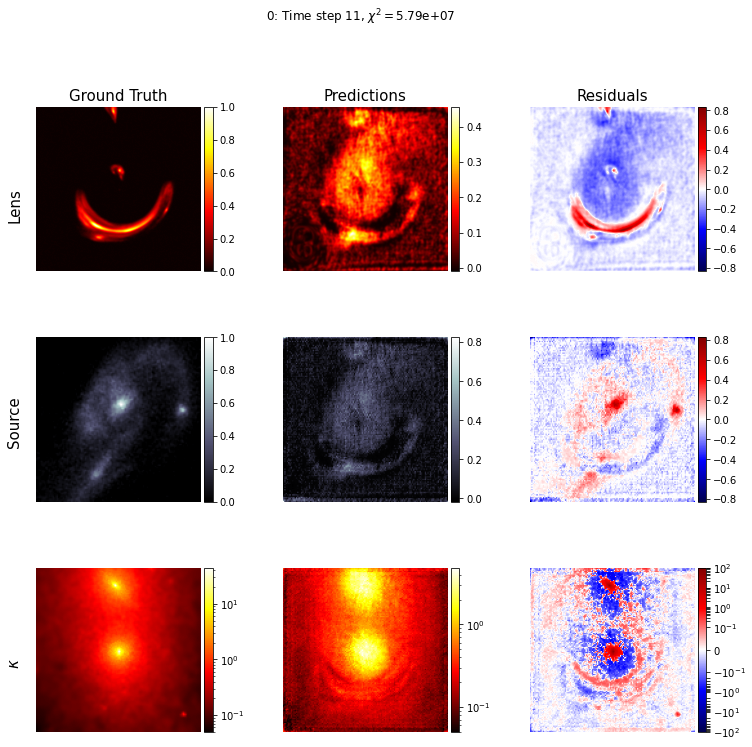

In [160]:
for batch, distributed_inputs in enumerate(train_dataset):
    for res_idx in range(args.batch_size):
        lens_true = distributed_inputs[0][res_idx]
        lens_true /= tf.reduce_max(lens_true, axis=(0, 1, 2), keepdims=True)
        source_true = distributed_inputs[1][res_idx]
        kappa_true = distributed_inputs[2][res_idx]
        source_pred, kappa_pred, chi_squared = rim.predict(lens_true[None])
        lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])[0]
#         lens_pred = tf.nn.relu(lens_pred)
#         lam = tf.reduce_sum(lens_true * lens_pred) / tf.reduce_sum(lens_true**2)[..., tf.newaxis, tf.newaxis, tf.newaxis]
        fig = residual_plot(lens_true, source_true, kappa_true, lens_pred, source_pred[-1][0, ...], kappa_pred[-1][0, ...], chi_squared[-1][0])
        fig.suptitle(fr"{batch}: Time step {args.steps+1}, $\chi^2 = ${chi_squared[-1][0]:.2e}")
    break

In [161]:
for X, source, kappa in train_dataset:
    break
self = rim
# self._kappa_init = args.kappa_init#0.9
# self._source_init = args.source_init
# self.physical_model.forward_method = "fft"
# self.adam = True
# self.beta_1 = 0.5
# self.beta_2 = 0.5
lensed_image = X
batch_size = lensed_image.shape[0]
source, kappa, states = self.initial_states(batch_size)
print(tf.reduce_mean(kappa))
source_series = tf.TensorArray(DTYPE, size=self.steps)
kappa_series = tf.TensorArray(DTYPE, size=self.steps)
chi_squared_series = tf.TensorArray(DTYPE, size=self.steps)
source_grad_series = tf.TensorArray(DTYPE, size=self.steps)
kappa_grad_series = tf.TensorArray(DTYPE, size=self.steps)
lens_series = tf.TensorArray(DTYPE, size=self.steps+1)

for current_step in range(self.steps):
#     kappa = self.kappa_link(kappa)
    with tf.GradientTape() as g:
        g.watch(source)
        g.watch(kappa)
        y_pred = self.physical_model.forward(source=self.source_link(source), kappa=self.kappa_link(kappa))
        log_likelihood = 0.5 * tf.reduce_sum((y_pred - lensed_image)**2/phys.noise_rms**2, axis=(1, 2, 3)) #+ 2000*tf.reduce_sum(source**2) #+ 100000*tf.reduce_sum(self.kappa_link(kappa))
        cost = tf.reduce_mean(log_likelihood)
    source_grad, kappa_grad = g.gradient(cost, [source, kappa])
    source_grad, kappa_grad = [tf.clip_by_value(grad/1e2, -100, 100) for grad in [source_grad, kappa_grad]]
#     source_grad, kappa_grad = [tf.nn.tanh(grad) for grad in [source_grad, kappa_grad]]

#     source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)
#     source, kappa, states = self.time_step(source, self.kappa_inverse_link(kappa), source_grad, kappa_grad, states)
    source, kappa, states = self.time_step(source, kappa, source_grad, kappa_grad, states)
    source_series = source_series.write(index=current_step, value=source)
    kappa_series = kappa_series.write(index=current_step, value=kappa)
    source_grad_series = source_grad_series.write(index=current_step, value=source_grad)
    kappa_grad_series = kappa_grad_series.write(index=current_step, value=kappa_grad)
    if current_step > 0:
        chi_squared_series = chi_squared_series.write(index=current_step-1, value=log_likelihood)
    lens_series.write(index=current_step, value=y_pred)
# last step score
y_pred = self.physical_model.forward(source=self.source_link(source), kappa=self.kappa_link(kappa))
log_likelihood = 0.5 * tf.reduce_sum((y_pred - lensed_image)**2/phys.noise_rms**2, axis=(1, 2, 3))
chi_squared_series = chi_squared_series.write(index=current_step, value=log_likelihood)
lens_series.write(index=current_step, value=y_pred)

s = source_series.stack()
k = kappa_series.stack()
grad_s = source_grad_series.stack()
grad_k = kappa_grad_series.stack()
lens = lens_series.stack()

tf.Tensor(0.00043409778, shape=(), dtype=float32)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/aadam/environments/censai3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3461, in run_code
    return outflag  File "<ipython-input-156-8b3327405ad1>", line 46, in <module>
    chi_squared_series = chi_squared_series.write(index=current_step, value=log_likelihood)  File "/home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originall

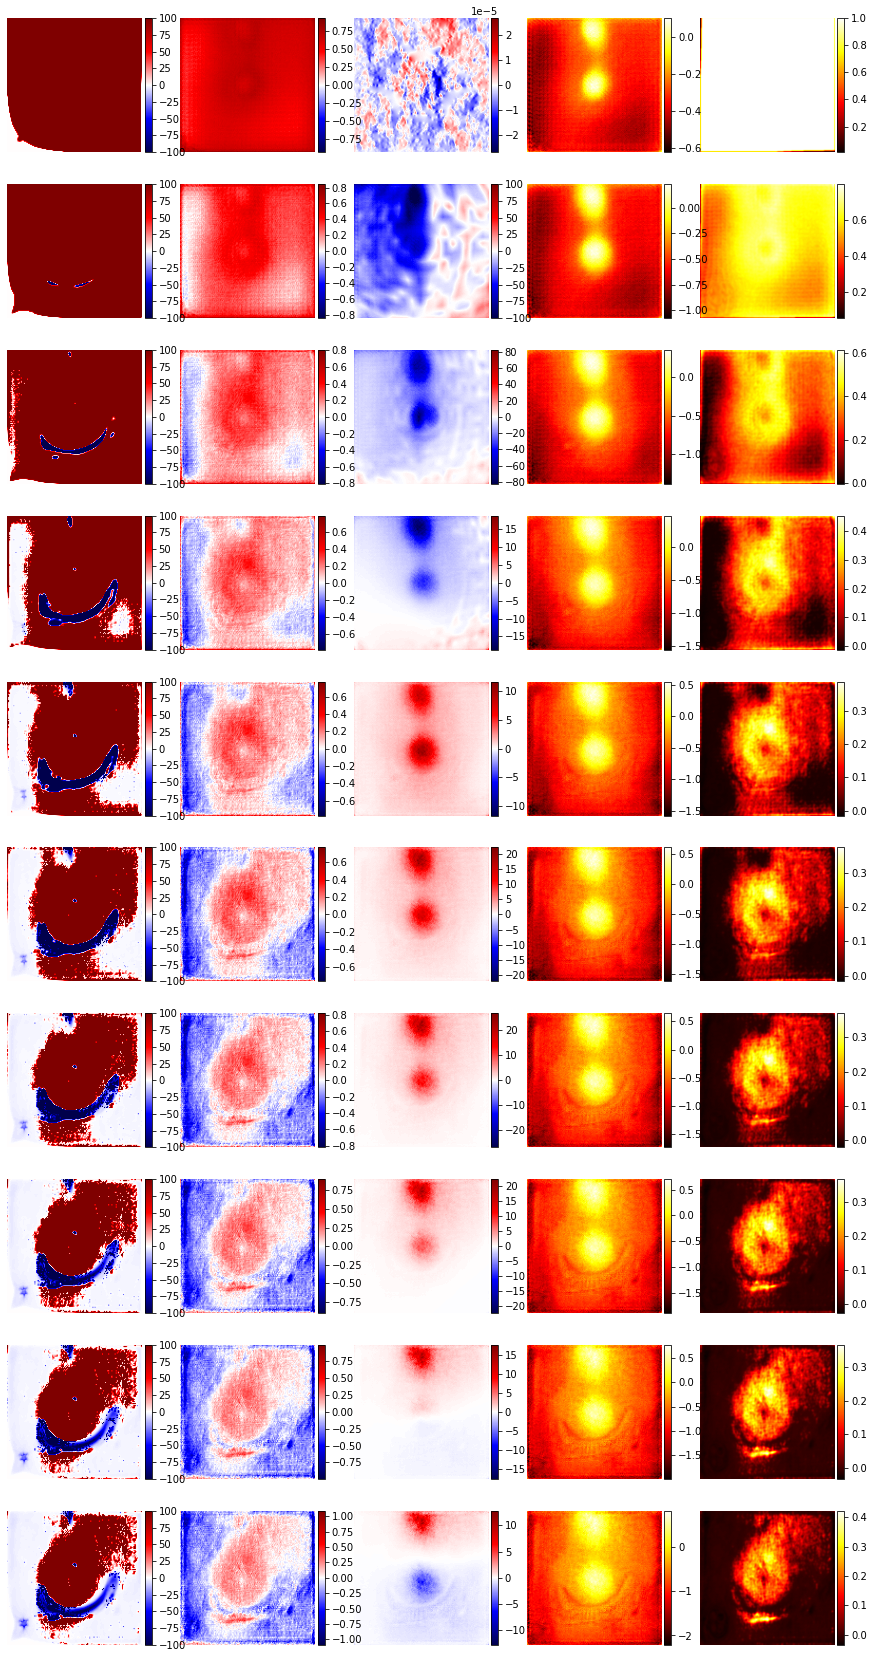

In [163]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axs = plt.subplots(args.steps, 5, figsize=(15, 3 * args.steps))
for i in range(args.steps):
    ax = axs[i, 0]
#     ax = axs[0]
    im = ax.imshow(grad_s[i, 0, ..., 0], cmap="seismic", norm=CenteredNorm(), origin="lower")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.axis("off")
    
    ax = axs[i, 1]
#     ax = axs[1]
    im = ax.imshow(s[i, 0, ..., 0], cmap="seismic", norm=CenteredNorm(), origin="lower")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.axis("off")
    
    ax = axs[i, 2]
#     ax = axs[1]
    im = ax.imshow(grad_k[i, 0, ..., 0], cmap="seismic", norm=CenteredNorm(), origin="lower")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.axis("off")
    
    ax = axs[i, 3]
#     ax = axs[1]
    im = ax.imshow(k[i, 0, ..., 0], cmap="hot", origin="lower")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.axis("off")
    
    ax = axs[i, 4]
#     ax = axs[1]
    im = ax.imshow(lens[i, 0, ..., 0], cmap="hot", origin="lower")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.axis("off")

In [210]:
# model_id = "RIMSU512_k128_NIE2nsvdO_007_TS10_F8_L4_IK7_NLrelu_al0.1_GAconcat_82_B10_lr0.0005_dr1.0_ds5000_TWquadratic_210923024919"
# import sys
# sys.argv = ['']
# args = parser.parse_args(
#   f"--model_id={os.getenv('CENSAI_PATH')}/models/{model_id} "\
#   f"--datasets {os.getenv('CENSAI_PATH')}/data/lenses512_hk128_TNG100_10k_verydiffuse "\
#   f"--compression_type=GZIP "\
#   f"--forward_method=fft "\
#   f"--optimizer=ADAM "\
#   f"--epochs=200 "\
#   f"--max_time=1 "\
#   f"--initial_learning_rate=1e-3 "\
#   f"--decay_rate=0.5 "\
#   f"--decay_steps=100 "\
#   f"--staircase "\
#   f"--clipping "\
#   f"--patience=20 "\
#   f"--tolerance=0.01 "\
#   f"--batch_size=10 "\
#   f"--train_split=1 "\
#   f"--total_items=1000 "\
#   f"--block_length=1 "\
#   f"--buffer_size=1000 "\
# #   f"--steps=10 "\
# #   f"--adam "\
# #   f"--kappalog "\
# #   f"--source_link=lrelu4p "\
# #   f"--filters=16 "\
# #   f"--filter_scaling=1.5 "\
# #   f"--kernel_size=3 "\
# #   f"--layers=5 "\
# #   f"--block_conv_layers=2 "\
# #   f"--resampling_kernel_size=3 "\
# #   f"--gru_kernel_size=3 "\
# #   f"--batch_norm "\
# #   f"--dropout=0.1 "\
# #   f"--upsampling_interpolation "\
# #   f"--kernel_l2_amp=1e-4 "\
# #   f"--bias_l2_amp=1e-4 "\
# #   f"--kernel_l1_amp=1e-3 "\5e-3
# #   f"--bias_l1_amp=1e-3 "\
# #   f"--activation=leaky_relu "\
# #   f"--alpha=0.3 "\
#   f"--cache_file={os.getenv('SLURM_TMPDIR')}/cache "\
#   f"--logdir={os.getenv('HOME')}/scratch/Censai/logs "\
#   f"--logname=RIMSU512_k128_pretrained_hTNG "\
#   f"--track_train "\
#   f"--model_dir={os.getenv('HOME')}/scratch/Censai/models "\
#   f"--checkpoints=5 "\
#   f"--max_to_keep=3 "\
#   f"--seed=42 "\
#   f"--n_residuals=0 "\
#   f"--json_override {os.getenv('CENSAI_PATH')}/models/{model_id}/unet_hparams.json {os.getenv('CENSAI_PATH')}/models/{model_id}/rim_hparams.json".split()

# )
# if args.json_override is not None:
#     if isinstance(args.json_override, list):
#         files = args.json_override
#     else:
#         files = [args.json_override,]
#     for file in files:
#         with open(file, "r") as f:
#             json_override = json.load(f)
#         args_dict = vars(args)
#         args_dict.update(json_override)
# cache_files = glob.glob(f"{os.getenv('SLURM_TMPDIR')}/cache*")
# for cache in cache_files:
#     os.remove(cache)
# rim, phys, train_dataset, val_dataset = main(args)